# Project Report

## Introduction

In this section, I will outline the steps I followed to address the problem and the rationale behind each action. To begin, I started by visualizing the time series data to identify any potential patterns or trends. To achieve this, I utilized the following code to generate the plot.

![image1](assets/1.svg)

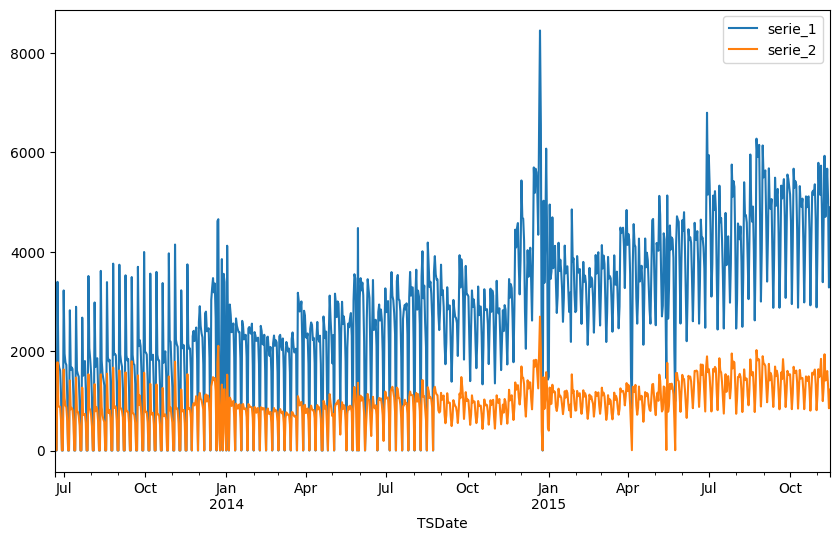

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import os
from dotenv import load_dotenv
load_dotenv()

PATH_FOR_TRAIN = os.getenv('PATH_FOR_TRAIN')

df = pd.read_csv(PATH_FOR_TRAIN, index_col='TSDate', parse_dates=['TSDate'])

#plot two figures in one, based on column serieNames (serie_1, serie_2) and vlaues of sales
fig, ax = plt.subplots(figsize=(10, 6))
df[df['serieNames'] == 'serie_1']['sales'].plot(ax=ax, label='serie_1')
df[df['serieNames'] == 'serie_2']['sales'].plot(ax=ax, label='serie_2')
plt.legend()

## The presence of zero values (without additional context) could be explained by the following hypotheses:

1. ***Stock Out**: There may have been a stock-out issue in 2013 where no sales occurred every Saturday. Interestingly, when the value for serie_1 is 0, the sales value for serie_2 is consistently 5. This indicates a significant correlation between the two series, with a correlation coefficient of 0.94 (based on upcoming models). In this case, serie_2 can be considered a complementary product, where low sales in one product may trigger a fixed demand for the other.
2. **Promotion**: A promotion could ensure a minimum fixed sale (e.g., 5) for serie_2 whenever serie_1 fails to sell.
3. **Data Artifact**: The zeros in serie_1 could be artifacts caused by system behavior. For example, if a threshold condition occurs where serie_1 equals zero, the system may automatically assign a value of 5 to serie_2.

---
## Addressing the Issue
To address this, several approaches can be tested to evaluate which one leads to the best results. However, due to time constraints and the limited information available in the sales data, I will focus on testing one of these approaches.

---
## Scenarios to Consider
1. **Treat Zero Values as Missing Data**:
Consider zeros as missing data and apply imputation techniques to fill them.
For example, imputing with the mean would imply predicting demand rather than sales (since demand should theoretically not be zero).
2. **Remove Zero Values**:
Removing all zero values could be an option, but this results in the loss of significant information.
3. **Remove Only Weekend Zero Values**:
Removing zeros only on weekends may seem viable, but it disrupts the temporal dependency in the time series, weakening the model's ability to predict weekend sales.
Segment the Data:
4. **Segmenting data into subsets** (e.g., weekend vs. weekday sales) can help, but it comes with limitations:
Separate training and testing for each segment may not generalize well across all time series.
Managing and aggregating predictions for 55,000 time series adds significant complexity.
5. **Using Models That Handle Missing Data and Feature Engineering**:
This approach is the most promising for an initial proof-of-concept model.
By performing feature engineering, we can create augmented features that allow the model to retain information from zero values while maintaining temporal dependency in the data.


---
Additionally, certain machine learning models are inherently robust to missing data.
## Experimentation Plan
For experimentation purposes, I will test the following two scenarios using MLflow and DagsHub to track results:

- Imputation: Replace values lower than or equal to 10 using forward filling and backward filling techniques.
- No Changes: Keep the zero values as they are without any modifications.
- We will then compare the performance of these two approaches by evaluating the RMSE on the validation set.

This experimentation will provide insights into the best strategy for handling zero values while balancing information retention and model robustness.

To properly model the problem, I put the data on a data ware house on Snowflake and I made a database and a table inside it for **data ingesiton purposes**. Before going to actually make a model, I decided to look inot features of the time-series data itself by looking at classicla time-series features such as arima model, autocorrelation and partial autocorelation.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings

warnings.filterwarnings("ignore")

# Function for time-series analysis plot
def tsplot(y, lags=None, title="Time Series Analysis", figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'{title}\n Dickey-Fuller: p={p_value:.5f}')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()






In [3]:
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
PATH_FOR_TRAIN = os.getenv('PATH_FOR_TRAIN')

df = pd.read_csv(PATH_FOR_TRAIN, index_col='TSDate', parse_dates=['TSDate'])

Time Series Analysis for Serie 1


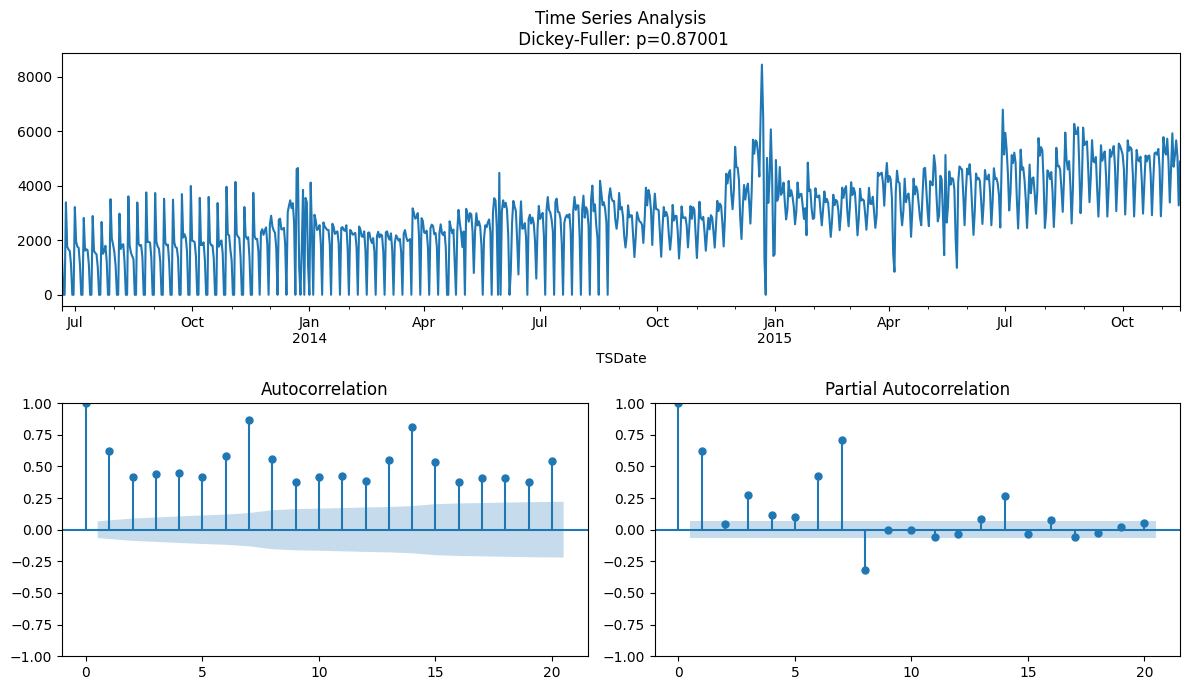

Time Series Analysis for Serie 2


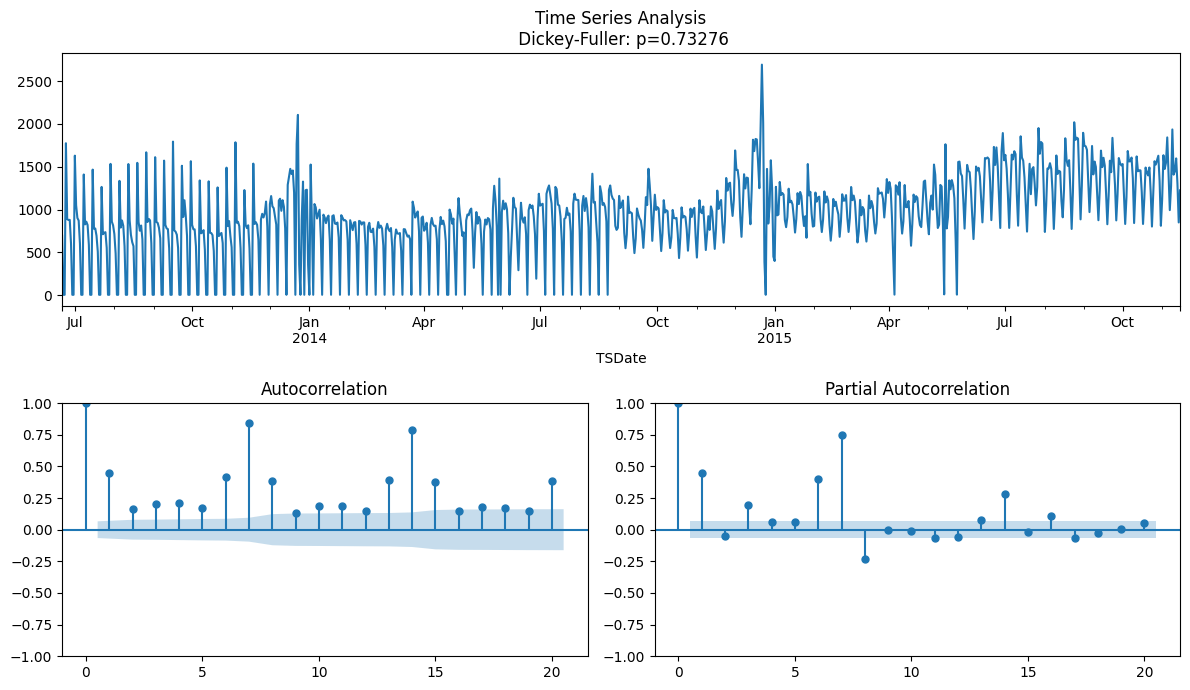

In [4]:
# Perform time-series analysis for each serie
# Split the time-series into two based on 'serieNames'
serie_1 = df[df['serieNames'] == 'serie_1']['sales']
serie_2 = df[df['serieNames'] == 'serie_2']['sales']


print("Time Series Analysis for Serie 1")
tsplot(serie_1.dropna(), lags=20)

print("Time Series Analysis for Serie 2")
tsplot(serie_2.dropna(), lags=20)

The time series appears to exhibit seasonality, with regular peaks. This suggests a recurring pattern, likely weekly or monthly. There are visible spikes in the data around January 2014 and January 2015, which could correspond to holidays or promotions.
The Dickey-Fuller test result (p=0.87001) suggests that the time series is non-stationary, as the p-value is greater than 0.05. A non-stationary series indicates:
- Trends over time
- Variance that is not constant
- Strong seasonal patterns
To make the series stationary, differencing or seasonal decomposition might be needed.


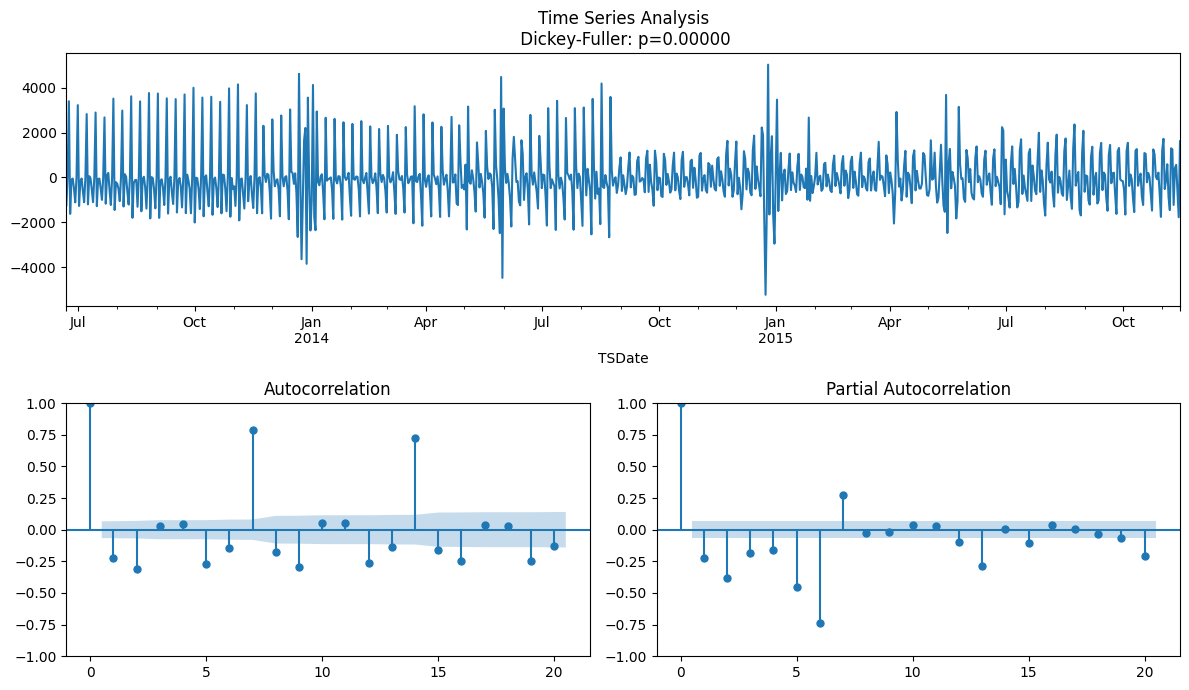

In [5]:
serie_1_diff = (serie_1 - serie_1.shift(1)).dropna()
tsplot(serie_1_diff.dropna(), lags=20)



Now, with one differencing applied, the series has become stationary. The ***Dickey-Fuller test*** result ```(p=0.0)``` confirms stationarity, indicating that the model should use ```d=1``` in the ARIMA or SARIMA configuration. The autocorrelation and partial autocorrelation plots also show that lag = 1 is significant. Therefore, ```ARIMA(1,1,1)``` appears to be a suitable choice for ```serie_1```. For the SARIMA model, a possible fit could be ```(1,1,1)(1,1,1,7)```, which accounts for weekly seasonality. The same behavior and parameters were observed for ```serie_2```.

One model that could be particularly beneficial for this type of problem is the **Vector Autoregressive model (VAR)**. VAR is a multivariate extension of the ARMA model that allows for the simultaneous modeling of multiple time series. It is a highly flexible approach that captures complex interdependencies between different series. When I applied the VAR model in ```RStudio``` (upon request I can deliver code or report for that part), I observed a strong fit with a correlation of ```0.94``` between the two time series.

However, the limitation of ARIMA and VAR models is their inability to scale efficiently to a large number of time series—such as ```55,000``` products in this case. These models perform well for a small number of series but become impractical to maintain and deploy at scale.

To address this challenge, I decided to focus on feature engineering to enhance the dataset with auxiliary features. Additionally, adding lag features (lag 1–7) transforms the time series data into a tabular format, enabling the use of powerful machine learning models such as ```Random Forest, XGBoost, LightGBM, and AdaBoost```. This approach ensures scalability and leverages the predictive strength of these advanced models.

## Feature Engineering



FOr dutch calendar and events i used , we can use the following code to get the holidays in the Netherlands. i used this linke https://github.com/PanderMusubi/dutch-holidays and code events. Also lag 1-7 days for each product added, plus parsing the full date into columns such as ```year, month, day, day of week, week of year, is_weekend```. I also did one experiment with only above extra columns, and experiment with one extra column: ```flag```, a binary column with values ```1```when we have ziro sales and ```0``` otherwise. Also, ```rolling_mean``` , ```rolling_std```, ```rolling_min and rolling_max``` were added to capture the trend and seasonality in the data. 

## Code flow

Figure below is showing at high-level how developed code works:

![Code flow](assets/Process.jpg)


A requirement.txt file included for required python packages. Also I ran all the analysis usign ```pipenv```. 

### Data Ingestion

For proper testing and development I put the code in snowflake. I first made a data warehouse, and then a databse and one table inside it with contains the full sales data. User need to put the credentials in a ```.env``` file to access the database. ```DataIngestion, Data validation and data transformaiton``` objects contain informaiton about type, directory and name of the data, that at each steps they used as an input for next steps.

![Data Ingestion](assets/Ingestion_process.jpg)

## Data Validation module
This module checks the data quality (i.e, missing data, numebr of columns, duplicated rows, etc) and then at the end checks for data drift in the test. I didnt have time to finish the data drift part, but I will do it in the future.

![Data Validation](assets/Data_Validation.jpg)

## Data Transformation
![Data Transformation](assets/data_trans.jpg)

## Models
I considered the following models for the problem:
- XGBoost
- LightGBM
- Catboost

For each of them I used cross-valdiation with ```nfolds=3``` with using ```GridSearch``` for testing different hyperparameters. Range of values for hyperparameters are defined in the ```TSForecasting/components/model_trainer.py``` file. For each model, train dataset was from ```2013-06-21``` to last 15 days of the original ```train.csv```. Last 15 days used as an validations set and at the end model will generate predictions for teh original ```test.csv``` file.

## Tracking

I used ```mlflow``` for model registry and experminet tracking. I used ```dagshub``` to log these information and host it on cloud. 

![Tracking](assets/dagshub1.png)

From these limited experiments, training with including sales value less 10 and adding the extra flag column resulted in lowest train and validation ```RMSE = 89.9 and RMSE=263``` , respectively. So this will be the model that I will use to predict the sales for the test data.

In [2]:
from TSForecasting.utils.main_utils.utils import load_object, load_numpy_array_data
import pandas as pd

chosen_model = load_object("final_model/model.pkl")
import os
df_test = load_numpy_array_data("/Users/Moaze002/Documents/cl_project/Artifacts/12_18_2024_13_28_04/data_transformation/transformed/test.npy")
template = pd.read_csv("/Users/Moaze002/Documents/cl_project/TSdata/test.csv")

<_io.BufferedReader name='final_model/model.pkl'>


In [3]:
x_test, y_test =   df_test[:, 1:-1], df_test[:, -1]

In [5]:
template['sales'] = chosen_model.predict(x_test)

In [6]:
template

,TSDate,serieNames,sales
0,2015-11-16,serie_2,1709.050388
1,2015-11-16,serie_1,4772.104072
2,2015-11-17,serie_1,4255.228710
3,2015-11-17,serie_2,1151.564103
4,2015-11-18,serie_1,4268.040000
5,2015-11-18,serie_2,1369.144495
6,2015-11-19,serie_1,4300.619048
7,2015-11-19,serie_2,1452.151786
8,2015-11-20,serie_2,1085.513216
9,2015-11-20,serie_1,4255.228710


<Axes: >

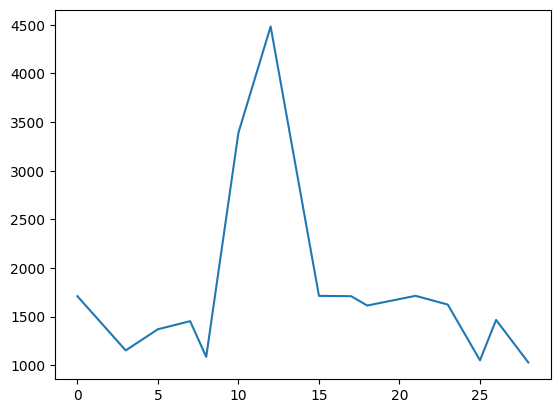

In [7]:
template[template['serieNames'] == 'serie_2']['sales'].plot()

## Visualization of train predictions

### Serie_1
![Serie_1](assets/trainserie1.png)


### Serie_2
![Serie_2](assets/trainserie2.png)


### Analysis figure above

The model demonstrated :

1. **Overfitting**: The train RMSE of 86 compared to the validation RMSE of 263 strongly suggests overfitting. Despite setting cv=3 and incorporating both L1 and L2 regularization, the model might still be overly complex. Adjusting the following parameters could help mitigate overfitting:
- Expand the range of max_depth and n_estimators in hyperparameter tuning.
- Increase the cv value to ensure better cross-validation performance.
- Experiment with stronger regularization values for L1 and L2 penalties.
- I should have time to test model with less augmented features and see if the model is overfitting or not. But certainly its an important step to do.


2. **Feature Importance**:
The feature set included auxiliary features like rolling averages, a 1-7-day lag, calendar events, weekdays, months, and years. While these features can capture seasonality and trends, the choice of a 1-7-day lag might not align well with the actual patterns in the data for ```serie_2```.
Some features may have had more predictive power in serie_1 than serie_2. Conducting feature importance analysis could identify which features drive the predictions in each series.


3. **Model Complexity**:
The selected hyperparameters might not fully capture the complexity of ```serie_2 and serie_1```. Using a wider search space during hyperparameter tuning, including varying learning_rate, subsample, and min_child_weight, could yield better results.

    - I didnt dive dipper into ARIMA and SARIMA, but again thats valuable information that can be used to improve the model, or the future approaches.

4. **Rolling Averages and Lags**:
Ensure that the auxiliary rolling averages and lag features are optimally configured. For instance, testing multiple rolling durations (e.g., 7, 14, 28 days) might better capture underlying seasonality or short-term trends.

5. **Regularization**:
Experiment with stronger L1 and L2 regularization to control model complexity and reduce overfitting. For now I have tested with some values, but more values can be tested.

## Extra: App

I also made a simple app that can be used to predict the sales for the test data. The app is made with ```fastapi```. Then I considere differetn routes for train an dprediciton. user can also upload test data points and model will save those in ```testouput``` folder. For launching the app in other environement a ```Dockerfile``` is also provided.

![App](assets/app.png)

For now the program can store and retrieve the trained model and preprocess.pkl files into ```Amazon s3``` bucket



## Extra: Deployement

For deployment, I considered to use ```.yml``` files in the ```.github/workflows``` folder. File ```infrapipilein.yml``` file will create 4 distinct environments for development area, staging area, deployment area and one workspakce for mlflow registry. The ```ci_cd.yml``` file can work and trigger the databricks envrioment. A short diagram of this process is as bellow:

![Deployement](assets/db_wks.jpg)


In the ```TSForecasting/cloud``` we have to put ARm templates and any .sh files to run on the cloud. I didnt have time to finish this part. Same procedure can eb applied for GCP.

## Future Work

1. Talking to the business stakeholders to get more information about the data and the problem aroudn ziros and 5 sales.
2. Using GPU based models that can handle 55000 time series data by considering time-series in their original forms (e.g., DeepAR)
3. Use recursive prediciton for test set. In other words, when model make a prediciton, we use this prediction to calculate lags1-7 and 
4. We can cluster products, and we may choose a model for each cluster. Then we have to main family of models.
5. To improve the performance of the POC, we can use ensemble models, such as stacking, to combine the predictions of multiple models.
6. If the ziro values are related to an outdated system procedure, we may also consider only trainig the model using the recent data from 2015.
7. An auxilary feature can also be considered by including autocorrealtion between prodcuts. In more detailed verison we cna include temporal autocorrelation (e.g. autocorelation in windows of 7 days).
8. We can also use the ```prophet``` model for time-series forecasting. This model is robust to missing data and can handle seasonality and holidays effectively.
9. Different Hyperparametr ranegs can be tested for each model.



## Closing

I want to thank you for giving me the oppertunity to work on this challangig problem. I am looking forward to hearing from you soon.